In [1]:
path = ""

In [2]:

# ## UNCOMMENT THIS CELL IF USING GOOGLE COLAB ###

# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

# # Enter the path in your Drive..
# FOLDERNAME = "Transformer"

# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append(f'/content/drive/My Drive/{FOLDERNAME}')

# path = f'/content/drive/My Drive/{FOLDERNAME}'

In [3]:
%load_ext autoreload
%autoreload 2

!pip install transformers

import os
import gc
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from utils2 import *
from dataset import *
from model import *
from Scheduler import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


cuda:0


In [4]:
data_folder = "WMT14 EN-GE/"

vocab_folder = os.path.join(data_folder,"vocab")
train_folder = os.path.join(data_folder,"train")
test_folder = os.path.join(data_folder,"test")
mappings_path = os.path.join(data_folder,"dict.en-de")

folders_map = {"train":train_folder,"test":test_folder}

In [5]:
!pip install wget
import wget

for folder in [data_folder, vocab_folder, train_folder, test_folder]:
  if not(os.path.exists(folder)):
    os.mkdir(folder)

urls_to_load = {"https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.en":vocab_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.de":vocab_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.en":train_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/newstest2012.en":test_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.de":train_folder,
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/newstest2012.de":test_folder}  # a list to store the urls

files_namings = {"https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.en":"vocab.en",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.de":"vocab.de",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.en":"train.en",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/newstest2012.en":"test.en",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.de":"train.de",
                "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/newstest2012.de":"test.de"}

# starting to download
print("Starting downloading")
for url,dir in urls_to_load.items():
    file_name = dir + '/' + files_namings[url] # get the full path to the file
    if not(os.path.exists(file_name)):
     # if doesn't exists, download it.
        file_name = wget.download(url, out=file_name)
        print(file_name)

print("ok")

Starting downloading



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ok


In [6]:
data_map = {"en":{"train":[],"test":[],"val":[]},
             "de":{"train":[],"test":[],"val":[]}}

data_text = extractTextFromFolders(folders_map,data_map,val_split = 0.75, limit = 3e4)

extracting text from folders ...:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
tokenizer = create_train_bpe_tokenizer(folders_map,data_map, tokenizers_path = os.path.join(path,f"tokenizers"))

True tokenizers\tokenizer_shared.json
loading pretrained  ....tokenizers\tokenizer_shared.json


In [8]:
tokenizer.decode(tokenizer.encode_batch(["Hi !", "How are you gneingieinhgeinh ?"],)[1].ids)

'How are you gn ein gi ein h g ein h ?'

In [9]:
data_tokens = extractTokens(data_text,tokenizer)

extracting tokens ...:   0%|          | 0/2 [00:00<?, ?it/s]

214 214
214 214
214 214
214 214


In [10]:
data_encodings = extractEncodings(data_tokens)

extracting encodings ...:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
print(tokenizer.decode(data_encodings["en"]["train"][5155].tolist()))
print(tokenizer.decode(data_encodings["de"]["train"][5155].tolist()))

It has a sem i trop ical clim ate , a short w inter ( j une and j ul y ) , and the temperatur e the rest of the year ran ges between 22 to 35 de gre es cen tig ra de .
Das annähernd trop ische Klima besch ert kurze Winter mit gemäß igten Temperaturen ( im Juni und Juli ) und lange Sommer mit Tage stemperatur en zwischen 22 und 35 Grad Cel sius .


In [12]:
wmt_train = WMT(inpt_encodings=data_encodings["en"]["train"],tgt_encodings=data_encodings["de"]["train"],
                eos_index = tokenizer.token_to_id("[EOS]"), pad_index = tokenizer.token_to_id("[PAD]"))
wmt_val = WMT(inpt_encodings=data_encodings["en"]["val"],tgt_encodings=data_encodings["de"]["val"],
              eos_index = tokenizer.token_to_id("[EOS]"), pad_index = tokenizer.token_to_id("[PAD]"))
wmt_test = WMT(inpt_encodings=data_encodings["en"]["test"],tgt_encodings=data_encodings["de"]["test"],
               eos_index = tokenizer.token_to_id("[EOS]"), pad_index = tokenizer.token_to_id("[PAD]"))

In [13]:
batch_size = 64
trainLoaders = {}

train_dataloader = DataLoader(wmt_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(wmt_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(wmt_test, batch_size=batch_size, shuffle=True)


trainLoaders["train"] = train_dataloader
trainLoaders["val"] = val_dataloader


## Generating an example ##
for i,batch in enumerate(iter(val_dataloader)):

    inputs,targets = batch["input"],batch["target"]
    idx = np.random.randint(0,len(inputs))
    if i < 1:
        print(f"inputs batch shape: {inputs['encodings'].size()}")
        print(f"targets batch shape: {targets['decoder_input_encodings'].size()}")
        sample = (inputs["encodings"][idx],targets["decoder_input_encodings"][idx])
        print(f"encodings : {sample[0]}")
        print(f"masks : {inputs['masks'][idx]}")
        print(f"masks : {inputs['masks'].shape}")
        print(f"masks : {targets['masks'][idx]}")
        print(f"masks : {targets['masks'].shape}")

        print(tokenizer.decode(sample[0].tolist()),"\n",
             tokenizer.decode(sample[1].tolist()))
        break

inputs batch shape: torch.Size([64, 213])
targets batch shape: torch.Size([64, 213])
encodings : tensor([ 9268,  2741,  5598, 16424,  3230, 13081,  2756,    17,     6,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,   

In [14]:
model = Transformer(src_vocabSize = tokenizer.get_vocab_size(),
                    tgt_vocabSize = tokenizer.get_vocab_size(),
                    src_max_len = data_encodings["en"]["train"].shape[1],
                    tgt_max_len = data_encodings["de"]["train"].shape[1],
                    noHeads = 8,
                    d_model = 512,
                    d_ff = 2048,
                    dropout = 0.1,
                    noEncoder = 1,
                    noDecoder = 1,
                    pad_index = tokenizer.token_to_id("[PAD]"),
                   device = device).to(device)

for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

In [15]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.0001,
                             betas = (0.9, 0.98),
                              eps = 1.0e-9)

In [16]:
scheduler = Scheduler(optimizer =  optimizer,
                 dim_embed= 512,
                 warmup_steps=400)

In [17]:
print(f"Numeber of the model's trainable paramaters : {count_parameters(model)}")


Numeber of the model's trainable paramaters : 38101296


In [35]:
## An example of the untrained model prediction ##
model.eval()
out = torch.softmax(model(wmt_train[50:51]["input"], wmt_train[50:51]["target"]), dim = -1)
print(out.shape)

print(f"True label : {tokenizer.decode(wmt_train[50:51]['target']['target_encodings'][0].tolist())}")
print(f"Prediction : {tokenizer.decode(torch.argmax(out,2)[0].tolist())}")

## The prediction loss ##
loss = translationLoss(output=out, target=wmt_train[:1]["target"]["target_encodings"].to(device), pad_index = tokenizer.token_to_id("[PAD]"), label_smoothing = 0.1)
print(loss)

torch.Size([1, 213, 30000])
True label : Das Gesellschafts recht regelt die Handels gesellschaften sowie zahlreiche damit zusammenhängen de Bereiche , etwa das Bilanz recht . Man unterscheidet zwischen den Personen gesellschaften ( zum Beispiel der offenen Handels gesellschaft oder Kommand it gesellschaft ) sowie den Kapital gesellschaften ( zum Beispiel der Gesellschaft mit beschrän kter Haftung oder der Aktiengesellschaft ) .
Prediction : Das Gesellschafts recht regelt die Handels gesellschaften sowie zahlreiche damit zusammenhängen de Bereiche , etwa zur Bilanz recht . Man unterscheidet zwischen den Personen gesellschaften ( zum Beispiel der offenen Handels gesellschaft oder Kommand it gesellschaft ) sowie das Kapital gesellschaften ( zum Beispiel der Gesellschaft mit beschrän kter Haftung oder der Aktiengesellschaft ) . durch durch durch kter kter kter kter kter ) werden werden werden werden ) . werden werden werden . . . werden werden werden werden werden werden werden werden werd

In [19]:
if not (os.path.exists("trained")):
        os.mkdir("trained")

filename = "transformer-weights-small"

In [20]:
train_cum_losses, val_cum_losses = [], []

In [ ]:
trainedModel, train_losses, val_losses = train_model(model, trainLoaders, translationLoss, optimizer,
                           pad_index = tokenizer.token_to_id("[PAD]"), label_smoothing = 0.1,
                           scheduler = scheduler, num_epochs=10, device = device, isSave=True,
                           filename = filename, verbose = False)

train_cum_losses += train_losses
val_cum_losses += val_losses

torch.save(model.state_dict(), f"trained/{filename}")
!cp -r './trained/transformer-weights-small' /content/drive/MyDrive/

Epoch 0/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 0
train current epoch Loss: 4.478027560494163, lr = 0.0004230512103551702


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 0
val current epoch Loss: 14.678071191755391, lr = 0.0004230512103551702
Epoch 1/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 4.478027560494163
train current epoch Loss: 4.464415046301755, lr = 0.0004163891663583844


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 14.678071191755391
val current epoch Loss: 14.655150090233754, lr = 0.0004163891663583844
Epoch 2/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 4.464415046301755
train current epoch Loss: 4.451736703515053, lr = 0.0004100322580145989


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 14.655150090233754
val current epoch Loss: 14.679345316806081, lr = 0.0004100322580145989
Epoch 3/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 4.451736703515053
train current epoch Loss: 4.436179906129837, lr = 0.0004039578815785102


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 14.679345316806081
val current epoch Loss: 14.706030603182517, lr = 0.0004039578815785102
Epoch 4/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 4.436179906129837
train current epoch Loss: 4.427711118351329, lr = 0.00039814571012756057


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 14.706030603182517
val current epoch Loss: 14.694004075001862, lr = 0.00039814571012756057
Epoch 5/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 4.427711118351329
train current epoch Loss: 4.408903326500546, lr = 0.0003925774069367083


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 14.694004075001862
val current epoch Loss: 14.697143805229057, lr = 0.0003925774069367083
Epoch 6/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 4.408903326500546
train current epoch Loss: 4.394964968616312, lr = 0.00038723638175549365


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 14.697143805229057
val current epoch Loss: 14.71812430882858, lr = 0.00038723638175549365
Epoch 7/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 4.394964968616312
train current epoch Loss: 4.386588952758095, lr = 0.0003821075825990294


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 14.71812430882858
val current epoch Loss: 14.7111690650552, lr = 0.0003821075825990294
Epoch 8/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 4.386588952758095
train current epoch Loss: 4.378673472187736, lr = 0.000377177317094821


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 14.7111690650552
val current epoch Loss: 14.698359885458219, lr = 0.000377177317094821
Epoch 9/9
----------


Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

train prev epoch Loss: 4.378673472187736
train current epoch Loss: 4.369556936350736, lr = 0.00037243309855168795


Predicting ...:   0%|          | 0/118 [00:00<?, ?it/s]

val prev epoch Loss: 14.698359885458219
val current epoch Loss: 14.678494453430176, lr = 0.00037243309855168795

Training complete in 46m 58s
Best val loss: 14.655150


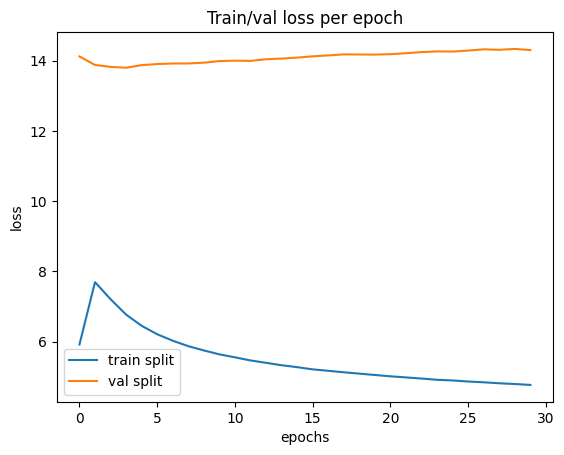

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(np.arange(len(train_cum_losses)), train_cum_losses, label = 'train split')
ax.plot(np.arange(len(val_cum_losses)), val_cum_losses, label = "val split")

ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.set_title("Train/val loss per epoch")
ax.legend()

plt.show()

In [ ]:
results = evaluate_model(model, train_dataloader, tokenizer, device = device)

Predicting ...:   0%|          | 0/352 [00:00<?, ?it/s]

 Result : 0.15630781650543213

Evaluating complete in 1m 31s


In [21]:
model.load_state_dict(torch.load(os.path.join(path,os.path.join("trained",filename))))

<All keys matched successfully>

In [40]:
for i,batch in enumerate(iter(train_dataloader)):

    inputs,targets = batch["input"],batch["target"]
    idx = np.random.randint(0,len(inputs))
    if i < 1:
        sample = (inputs["encodings"][idx],targets["decoder_input_encodings"][idx])

        print(f"Input English Sentence : {tokenizer.decode(sample[0].tolist())}")
        print(f"Input German Sentence (Translated) : {tokenizer.decode(sample[1].tolist())}")
        
        model.eval()
        out = torch.softmax(model(inputs, targets),dim = -1)
        print(out.shape)

        print(f"Predicted German Sentence (Translated) : {tokenizer.decode(torch.argmax(out[idx],1).tolist())}")

        loss = translationLoss(output = out, target = targets['target_encodings'].to(device), pad_index = tokenizer.token_to_id("[PAD]"), label_smoothing = 0.1)
        print(loss)

        bleu_score = score(out, targets, tokenizer, kind = "bleu")
        print(bleu_score)

        break



Input English Sentence : In order for us to be able to sen d you the gu ides you have re que sted , please be sure to f ill out all require d fiel ds ( ## STAR ## ) .
Input German Sentence (Translated) : Damit wir Ihnen die ange forderten Führer auch zu senden können , füllen Sie bitte alle relevanten Felder ( ## STAR ## ) aus .


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB (GPU 0; 4.00 GiB total capacity; 7.37 GiB already allocated; 0 bytes free; 9.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
# !cp -r './trained/transformer-weights' /content/drive/MyDrive/

In [41]:
infer(model.to(device), "In order for us to be able to sen d you the gu ides you have re que sted , please be sure to f ill out all require d fiel ds", tokenizer, device = device)

Input English Sentence : In order for us to be able to sen d you the gu ides you have re que sted , please be sure to f ill out all require d fiel ds


'Um uns ein , uns ein , zu können , alle relevanten Felder , ist es möglich , alle relevanten Informationen zu senden .'